Developed by **Chang Ye** @ 09-05-2025

Feel free to contect me via email: chang.ye@my.cityu.edu.hk | and obtain the latest version from github: https://github.com/Yechang618/Quant-Analysis-example.git


---


This is a comprehensive Python-based backtesting framework for developing and testing quantitative trading strategies using real-world market data.



**Section 0** Install the python libraries in case they are not installed by default. Please comment this block if you don't need it.

In [1]:
!pip install yfinance pandas matplotlib

**Section 1** Library loading

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

**Section 2** Source code of BacktestEngine. It includes several methods.

1.  **fetch_data**: real-time data fetching - automatically retrieves OHLCV data from Yahoo Finance.
2.  **calculate_technical_indicators**: calculate technical indicators such as moving averages, MACD, and so on.
3.  **generate_signals** apply different strategies to determine trade operations. Note that for the signal, 0: hold, 1: buy, -1: sell.
4.  **run_backtest** execute the backtest.
5.  **calculate_performance_metrics** calculate performance metrics, including sharpe ratio, Sortino ratio, drawdown analysis, and benchmark comparison.
6.  **plot_results**: Compare strategy performance against major indices (S&P 500, NASDAQ, etc.) with benchmark and visualize with interactive plots showing equity curves, drawdowns, signals, and technical indicators.

In [3]:
# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
### Here is the main structure of BacktestEngine
class BacktestEngine:
    """A comprehensive backtesting engine for trading strategies with real-world data"""

    def __init__(self, initial_capital=10000, commission=0.001, slippage=0.0005):
        self.initial_capital = initial_capital
        self.commission = commission  # 0.1% commission
        self.slippage = slippage     # 0.05% slippage
        self.results = None

    def fetch_data(self, ticker, start_date, end_date, interval='1d'):
        """Fetch real-world data from Yahoo Finance"""
        print(f"Fetching data for {ticker} from {start_date} to {end_date}...")

        try:
            data = yf.download(ticker, start=start_date, end=end_date, interval=interval)

            if data.empty:
                raise ValueError(f"No data found for {ticker} in the specified date range")

            # Validate required columns
            required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
            for col in required_cols:
                if col not in data.columns:
                    raise ValueError(f"Missing required column: {col}")

            # Clean data
            data = data.dropna()
            data = data[~data.index.duplicated(keep='first')]
            data.columns = data.columns.droplevel(-1)
            print(f"Data fetched: {len(data)} records from {data.index[0]} to {data.index[-1]}")
            self.data = data
            return data

        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def calculate_technical_indicators(self):
        """Calculate common technical indicators"""
        df = self.data.copy()

        # Moving Averages
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['SMA_200'] = df['Close'].rolling(window=200).mean()
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()

        # MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # CORRECTED: Bollinger Bands - FIXED THE ERROR
        bb_middle = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()

        df['BB_Middle'] = bb_middle
        df['BB_Upper'] = bb_upper = bb_middle + (bb_std * 2)
        df['BB_Lower'] = bb_lower = bb_middle - (bb_std * 2)
        df['BB_Width'] = (bb_upper - bb_lower) / bb_middle

        # Stochastic Oscillator
        low_14 = df['Low'].rolling(window=14).min()
        high_14 = df['High'].rolling(window=14).max()
        df['%K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
        df['%D'] = df['%K'].rolling(window=3).mean()

        # ATR (Average True Range) - CORRECTED
        high_low = df['High'] - df['Low']
        high_close = np.abs(df['High'] - df['Close'].shift())
        low_close = np.abs(df['Low'] - df['Close'].shift())
        # Use concat with axis=1 to create DataFrame, then take max along axis=1
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        bb_ART = true_range.rolling(window=14).mean()
        df['ATR'] = bb_ART
        df['ATR_Pct'] = bb_ART / df['Close'] * 100

        # Volume indicators
        bb_SMA_20 = df['Volume'].rolling(window=20).mean()
        df['Volume_SMA_20'] = bb_SMA_20
        df['Volume_Ratio'] = df['Volume'] / bb_SMA_20

        # Price momentum
        df['Momentum_5'] = df['Close'].pct_change(5)
        df['Momentum_20'] = df['Close'].pct_change(20)

        self.data = df
        return df

    def generate_signals(self, strategy='trend_following'):
        """Generate trading signals based on different strategies"""
        df = self.data.copy()
        df['signal'] = 0  # 0: hold, 1: buy, -1: sell

        if strategy == 'mean_reversion':
            # Buy when price is 2% below lower Bollinger Band, sell when 2% above upper
            df['signal'] = np.where(df['Close'] < df['BB_Lower'] * 0.98, 1,
                                  np.where(df['Close'] > df['BB_Upper'] * 1.02, -1, 0))

        elif strategy == 'trend_following':
            # Buy when price above SMA_200 and SMA_20 > SMA_50
            df['signal'] = np.where((df['Close'] > df['SMA_200']) &
                                  (df['SMA_20'] > df['SMA_50']), 1,
                                  np.where(df['Close'] < df['SMA_200'], -1, 0))

        elif strategy == 'macd_crossover':
            # Buy when MACD crosses above signal line and both are positive
            df['signal'] = np.where((df['MACD'] > df['MACD_Signal']) &
                                  (df['MACD'] > 0), 1,
                                  np.where((df['MACD'] < df['MACD_Signal']) &
                                         (df['MACD'] < 0), -1, 0))

        elif strategy == 'rsi_momentum':
            # Buy when RSI crosses above 30 from below, sell when crosses below 70 from above
            rsi_above_30 = (df['RSI'] > 30) & (df['RSI'].shift(1) <= 30)
            rsi_below_70 = (df['RSI'] < 70) & (df['RSI'].shift(1) >= 70)
            df['signal'] = np.where(rsi_above_30, 1,
                                  np.where(rsi_below_70, -1, 0))

        elif strategy == 'breakout':
            # Buy when price breaks above 20-day high, sell when breaks below 20-day low
            df['20d_high'] = df['High'].rolling(window=20).max()
            df['20d_low'] = df['Low'].rolling(window=20).min()
            df['signal'] = np.where(df['Close'] > df['20d_high'].shift(1), 1,
                                  np.where(df['Close'] < df['20d_low'].shift(1), -1, 0))

        # Remove signals where indicators are NaN
        df['signal'] = df['signal'].replace(0, np.nan).ffill().fillna(0)

        # Add signal strength (optional)
        df['signal_strength'] = abs(df['signal']) * df['Volume_Ratio']

        self.data = df
        return df

    def run_backtest(self, strategy='trend_following'):
        """Run the backtest with the selected strategy"""
        print(f"Running backtest with {strategy} strategy...")

        # Calculate indicators and generate signals
        self.calculate_technical_indicators()
        self.generate_signals(strategy)

        df = self.data.copy()
        capital = self.initial_capital
        position = 0
        trades = []
        equity_curve = []

        for i, row in df.iterrows():
            current_price = row['Close'] * (1 + np.random.normal(0, self.slippage))

            # Execute trades based on signals
            if row['signal'] == 1 and position == 0:  # Buy signal
                # Risk management: 2% of capital per trade, stop loss at 2x ATR
                risk_amount = capital * 0.02
                stop_loss = current_price - (row['ATR'] * 2)

                if current_price > stop_loss > 0:
                    position_size = risk_amount / (current_price - stop_loss)
                    position_size = min(position_size, capital / current_price)

                    cost = position_size * current_price * (1 + self.commission)
                    if cost <= capital:
                        capital -= cost
                        position = position_size
                        trades.append({
                            'date': i,
                            'action': 'BUY',
                            'price': current_price,
                            'size': position_size,
                            'capital': capital,
                            'stop_loss': stop_loss,
                            'strategy': strategy
                        })

            elif row['signal'] == -1 and position > 0:  # Sell signal
                proceeds = position * current_price * (1 - self.commission)
                capital += proceeds
                buy_price = trades[-1]['price'] if trades else current_price
                trades.append({
                    'date': i,
                    'action': 'SELL',
                    'price': current_price,
                    'size': position,
                    'capital': capital,
                    'pnl': proceeds - (position * buy_price),
                    'pnl_pct': (current_price / buy_price - 1) * 100,
                    'strategy': strategy
                })
                position = 0

            # Check stop loss
            if position > 0 and trades and 'stop_loss' in trades[-1]:
                if current_price <= trades[-1]['stop_loss']:
                    proceeds = position * current_price * (1 - self.commission)
                    capital += proceeds
                    buy_price = trades[-1]['price']
                    trades.append({
                        'date': i,
                        'action': 'SELL_STOP',
                        'price': current_price,
                        'size': position,
                        'capital': capital,
                        'pnl': proceeds - (position * buy_price),
                        'pnl_pct': (current_price / buy_price - 1) * 100,
                        'strategy': strategy
                    })
                    position = 0

            # Calculate current equity
            current_equity = capital + (position * current_price)
            equity_curve.append({
                'date': i,
                'equity': current_equity,
                'price': current_price,
                'position': position,
                'returns': (current_equity / self.initial_capital - 1) * 100
            })

        # Convert to DataFrames
        equity_df = pd.DataFrame(equity_curve).set_index('date')
        trades_df = pd.DataFrame(trades)

        if not trades_df.empty:
            trades_df.set_index('date', inplace=True)

        self.equity_curve = equity_df
        self.trades = trades_df
        self.final_capital = equity_df['equity'].iloc[-1]

        return equity_df, trades_df

    def calculate_performance_metrics(self, benchmark_ticker='^GSPC'):
        """Calculate comprehensive performance metrics with benchmark comparison"""
        if self.equity_curve is None:
            raise ValueError("Run backtest first")

        equity = self.equity_curve['equity']
        returns = equity.pct_change().dropna()

        # Basic metrics
        total_return = (equity.iloc[-1] / equity.iloc[0] - 1) * 100
        annual_return = (1 + total_return/100) ** (252/len(equity)) - 1

        # Benchmark comparison
        benchmark_data = yf.download(benchmark_ticker, start=self.data.index[0], end=self.data.index[-1])
        benchmark_returns = benchmark_data['Close'].pct_change().dropna()
        benchmark_total_return = (benchmark_data['Close'].iloc[-1] / benchmark_data['Close'].iloc[0] - 1) * 100

        # Volatility and risk metrics
        volatility = returns.std() * np.sqrt(252) * 100
        sharpe_ratio = (annual_return / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0

        # Drawdown analysis
        rolling_max = equity.expanding().max()
        drawdown = (equity - rolling_max) / rolling_max * 100
        max_drawdown = drawdown.min()

        # Sortino ratio (only downside volatility)
        downside_returns = returns[returns < 0]
        downside_volatility = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino_ratio = (annual_return / downside_volatility) * np.sqrt(252) if downside_volatility != 0 else 0

        # Trade analysis
        trade_metrics = self._analyze_trades()

        metrics = {
            'Initial Capital': self.initial_capital,
            'Final Capital': self.final_capital,
            'Total Return (%)': total_return,
            'Annual Return (%)': annual_return * 100,
            'Benchmark Return (%)': benchmark_total_return,
            'Alpha (%)': total_return - benchmark_total_return,
            'Volatility (%)': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown (%)': max_drawdown,
            'Calmar Ratio': (annual_return * 100) / abs(max_drawdown) if max_drawdown != 0 else 0,
            **trade_metrics
        }

        self.metrics = metrics
        self.benchmark_data = benchmark_data
        return metrics

    def _analyze_trades(self):
        """Analyze trade performance"""
        if self.trades.empty:
            return {
                'Number of Trades': 0,
                'Win Rate (%)': 0,
                'Avg Profit (%)': 0,
                'Avg Loss (%)': 0,
                'Profit Factor': 0,
                'Avg Hold Days': 0
            }

        # Get sell trades only
        sell_trades = self.trades[self.trades['action'].isin(['SELL', 'SELL_STOP'])]

        if len(sell_trades) == 0:
            return {
                'Number of Trades': 0,
                'Win Rate (%)': 0,
                'Avg Profit (%)': 0,
                'Avg Loss (%)': 0,
                'Profit Factor': 0,
                'Avg Hold Days': 0
            }

        # Calculate trade metrics
        win_rate = (sell_trades['pnl'] > 0).mean() * 100
        avg_profit = sell_trades[sell_trades['pnl'] > 0]['pnl_pct'].mean() if len(sell_trades[sell_trades['pnl'] > 0]) > 0 else 0
        avg_loss = sell_trades[sell_trades['pnl'] <= 0]['pnl_pct'].mean() if len(sell_trades[sell_trades['pnl'] <= 0]) > 0 else 0
        profit_factor = abs(avg_profit / avg_loss) if avg_loss != 0 else float('inf')

        # Calculate average holding period
        buy_trades = self.trades[self.trades['action'] == 'BUY']
        hold_periods = []
        for sell_trade in sell_trades.itertuples():
            buy_trade = buy_trades[buy_trades.index < sell_trade.Index].iloc[-1] if not buy_trades[buy_trades.index < sell_trade.Index].empty else None
            if buy_trade is not None:
                hold_period = (sell_trade.Index - buy_trade.name).days
                hold_periods.append(hold_period)

        avg_hold_days = np.mean(hold_periods) if hold_periods else 0

        return {
            'Number of Trades': len(sell_trades),
            'Win Rate (%)': win_rate,
            'Avg Profit (%)': avg_profit,
            'Avg Loss (%)': avg_loss,
            'Profit Factor': profit_factor,
            'Avg Hold Days': avg_hold_days
        }

    def plot_results(self):
        """Plot comprehensive backtest results"""
        if self.equity_curve is None:
            raise ValueError("Run backtest first")

        fig, axes = plt.subplots(3, 2, figsize=(20, 15))

        # Price and signals
        axes[0, 0].plot(self.data.index, self.data['Close'], label='Close Price', linewidth=1, color='black')
        axes[0, 0].plot(self.data.index, self.data['SMA_50'], label='SMA 50', linestyle='--', alpha=0.7)
        axes[0, 0].plot(self.data.index, self.data['SMA_200'], label='SMA 200', linestyle='--', alpha=0.7)

        # Plot buy/sell signals
        if not self.trades.empty:
            buy_signals = self.trades[self.trades['action'] == 'BUY']
            sell_signals = self.trades[self.trades['action'].isin(['SELL', 'SELL_STOP'])]

            axes[0, 0].scatter(buy_signals.index, buy_signals['price'], color='green',
                          marker='^', s=100, label='Buy', alpha=0.7)
            axes[0, 0].scatter(sell_signals.index, sell_signals['price'], color='red',
                          marker='v', s=100, label='Sell', alpha=0.7)

        axes[0, 0].set_title('Price and Trading Signals')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Equity curve vs Benchmark
        equity_normalized = self.equity_curve['equity'] / self.equity_curve['equity'].iloc[0]
        benchmark_normalized = self.benchmark_data['Close'] / self.benchmark_data['Close'].iloc[0]

        axes[0, 1].plot(equity_normalized.index, equity_normalized, label='Strategy', linewidth=2)
        axes[0, 1].plot(benchmark_normalized.index, benchmark_normalized, label='Benchmark (S&P 500)', linewidth=2)
        axes[0, 1].set_title('Strategy vs Benchmark (Normalized)')
        axes[0, 1].set_ylabel('Normalized Value')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Equity curve
        axes[1, 0].plot(self.equity_curve.index, self.equity_curve['equity'], label='Equity Curve', linewidth=2)
        axes[1, 0].set_title('Equity Curve')
        axes[1, 0].set_ylabel('Capital ($)')
        axes[1, 0].grid(True)

        # Drawdown
        rolling_max = self.equity_curve['equity'].expanding().max()
        drawdown = (self.equity_curve['equity'] - rolling_max) / rolling_max * 100
        axes[1, 1].fill_between(self.equity_curve.index, drawdown, 0, alpha=0.3, color='red', label='Drawdown')
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 1].set_title('Drawdown')
        axes[1, 1].set_ylabel('Drawdown (%)')
        axes[1, 1].grid(True)

        # RSI
        axes[2, 0].plot(self.data.index, self.data['RSI'], label='RSI', linewidth=1)
        axes[2, 0].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
        axes[2, 0].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
        axes[2, 0].set_title('RSI Indicator')
        axes[2, 0].set_ylabel('RSI')
        axes[2, 0].set_ylim(0, 100)
        axes[2, 0].legend()
        axes[2, 0].grid(True)

        # MACD
        axes[2, 1].plot(self.data.index, self.data['MACD'], label='MACD', linewidth=1)
        axes[2, 1].plot(self.data.index, self.data['MACD_Signal'], label='Signal', linewidth=1)
        axes[2, 1].bar(self.data.index, self.data['MACD_Histogram'], alpha=0.3, label='Histogram')
        axes[2, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[2, 1].set_title('MACD Indicator')
        axes[2, 1].set_ylabel('MACD')
        axes[2, 1].legend()
        axes[2, 1].grid(True)

        plt.tight_layout()
        plt.show()

        # Plot performance metrics table
        if hasattr(self, 'metrics'):
            metrics_df = pd.DataFrame.from_dict(self.metrics, orient='index', columns=['Value'])
            print("\nPerformance Metrics:")
            print(metrics_df.to_string(float_format=lambda x: f'{x:.2f}'))

**Section 3**: Example run

Fetching data for AAPL from 2020-01-01 to 2023-12-31...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data fetched: 1006 records from 2020-01-02 00:00:00 to 2023-12-29 00:00:00

Testing TREND_FOLLOWING strategy
Running backtest with trend_following strategy...
Final Capital:  10215.86050807764
Total Return:  2.158605080776388
Benchmark Return:  Ticker
^GSPC    46.825359
dtype: float64
Alpha:  Ticker
^GSPC   -44.666754
dtype: float64
Number of Trades:  10
Win Rate:  30.0


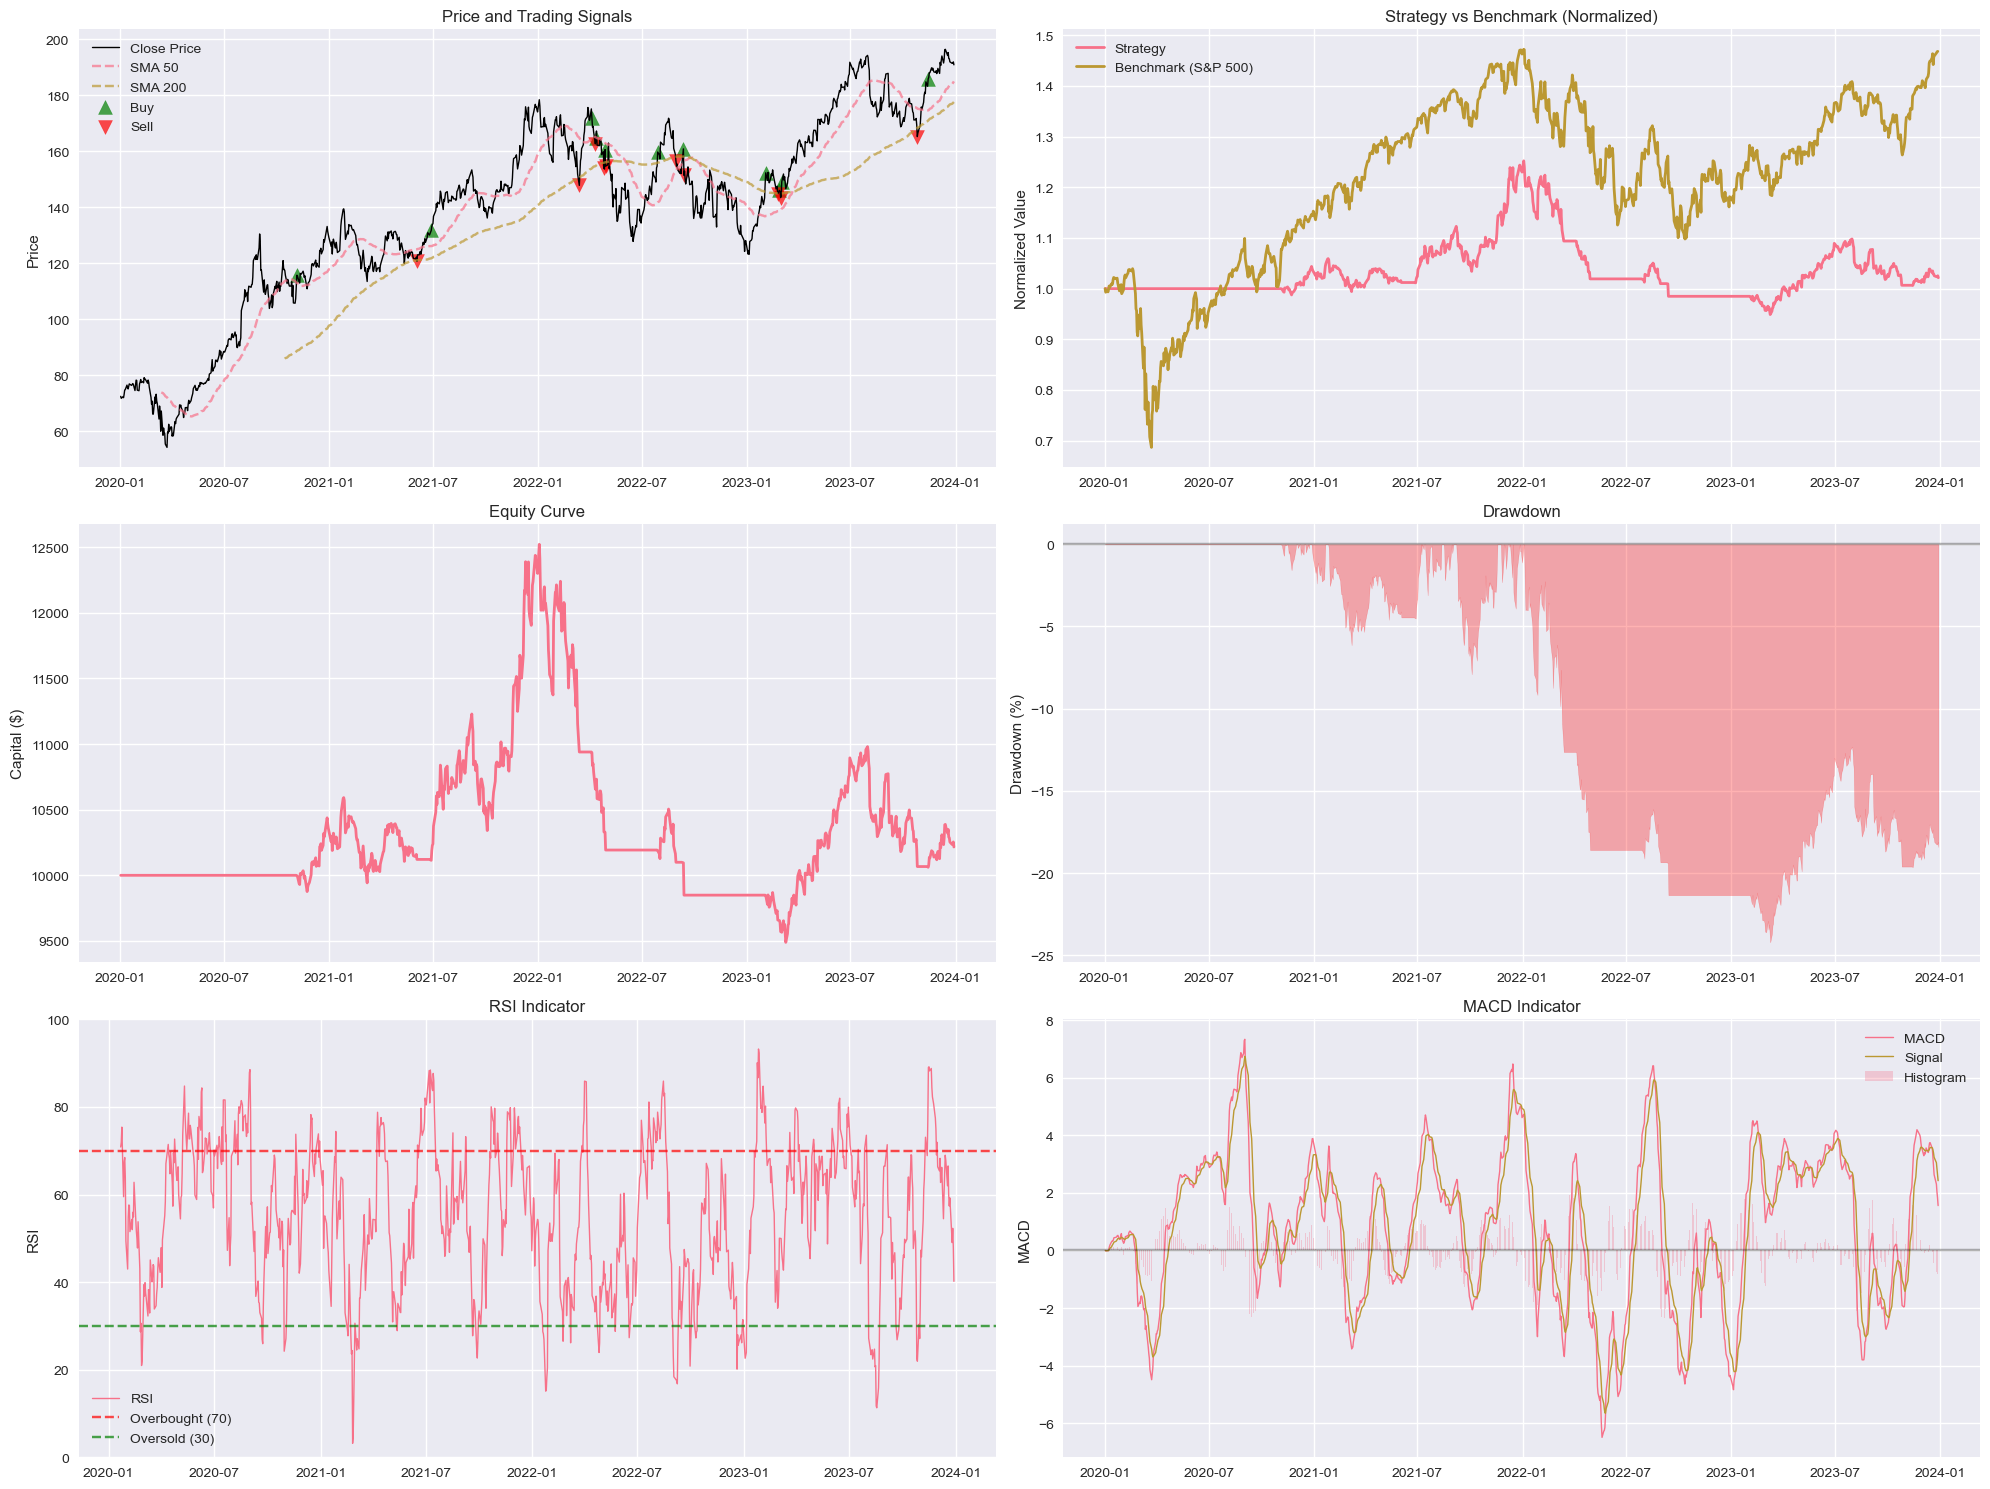

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Performance Metrics:
                                                         Value
Initial Capital                                          10000
Final Capital                                         10215.86
Total Return (%)                                          2.16
Annual Return (%)                                         0.54
Benchmark Return (%)  Ticker
^GSPC    46.825359
dtype: float64
Alpha (%)             Ticker
^GSPC   -44.666754
dtype: float64
Volatility (%)                                            9.64
Sharpe Ratio                                             14.02
Sortino Ratio                                             1.01
Max Drawdown (%)                                        -24.22
Calmar Ratio                                              0.02
Number of Trades                                            10
Win Rate (%)                                             30.00
Avg Profit (%)                                            9.17
Avg Loss (%)                     


[*********************100%***********************]  1 of 1 completed

Final Capital:  12249.754711442038
Total Return:  22.497547114420378
Benchmark Return:  Ticker
^GSPC    46.825359
dtype: float64
Alpha:  Ticker
^GSPC   -24.327812
dtype: float64
Number of Trades:  17
Win Rate:  35.294117647058826

STRATEGY COMPARISON
                Total Return (%)                      Benchmark Return (%)  \
trend_following         2.158605  Ticker
^GSPC    46.825359
dtype: float64   
mean_reversion          9.898398  Ticker
^GSPC    46.825359
dtype: float64   
macd_crossover         28.873213  Ticker
^GSPC    46.825359
dtype: float64   
rsi_momentum           -0.973702  Ticker
^GSPC    46.825359
dtype: float64   
breakout               22.497547  Ticker
^GSPC    46.825359
dtype: float64   

                                                Alpha (%) Sharpe Ratio  \
trend_following  Ticker
^GSPC   -44.666754
dtype: float64    14.021676   
mean_reversion   Ticker
^GSPC   -36.926961
dtype: float64   104.863728   
macd_crossover   Ticker
^GSPC   -17.952145
dtype: float64 

In [4]:
"""Main function to demonstrate backtesting with real data"""
### Initialize backtest engine
backtester = BacktestEngine(initial_capital=10000, commission=0.001, slippage=0.0005)

### Fetch real-world data (Apple stock)
# Here we select AAPL as the stock
# You may test other stock, such as tickers in https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'

data = backtester.fetch_data(ticker, start_date, end_date)

if data is None:
    print("Failed to fetch data. Exiting...")


### Test different strategies
strategies = ['trend_following', 'mean_reversion', 'macd_crossover', 'rsi_momentum', 'breakout']

results = {}
for strategy in strategies:
    print(f"\n{'='*60}")
    print(f"Testing {strategy.upper()} strategy")
    print(f"{'='*60}")

    # Run backtest
    equity, trades = backtester.run_backtest(strategy=strategy)

    # Calculate performance metrics
    metrics = backtester.calculate_performance_metrics(benchmark_ticker='^GSPC')
    results[strategy] = metrics

    # Print results
    print("Final Capital: ", metrics['Final Capital'])
    print("Total Return: ", metrics['Total Return (%)'])
    print("Benchmark Return: ", metrics['Benchmark Return (%)'])
    print("Alpha: ", metrics['Alpha (%)'])
    print("Number of Trades: ", metrics['Number of Trades'])
    print("Win Rate: ", metrics['Win Rate (%)'])

    # Plot results for the first strategy only to avoid too many plots
    if strategy == strategies[0]:
        backtester.plot_results()

### Compare strategies
print(f"\n{'='*80}")
print("STRATEGY COMPARISON")
print(f"{'='*80}")

comparison_df = pd.DataFrame(results).T
important_metrics = ['Total Return (%)', 'Benchmark Return (%)', 'Alpha (%)',
                    'Sharpe Ratio', 'Max Drawdown (%)', 'Win Rate (%)', 'Number of Trades']

print(comparison_df[important_metrics].round(2))